# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

### Dataset loading and preprocessing

In [2]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

In [3]:
data_matrix = df = pd.DataFrame()

data_matrix = pd.read_csv("Data_folder/Data_big_drop.csv", header= None)

#print(data_matrix)


# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:,3:].values
        y = data_matrix.iloc[0:,0:2].values
        x = np.random.normal(x,0.01)
        # Add normalization for x
        #x = preprocessing.normalize(x)
        print(x)

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)


[[-0.01039523  0.01833578  0.03306391 ... -0.0196759   0.00893284
  -0.00865336]
 [-0.00441018  0.01385455  0.05162874 ... -0.0260862   0.00023438
  -0.01077892]
 [ 0.00222165 -0.00298361  0.0368543  ... -0.01950658 -0.00219158
   0.00126349]
 ...
 [ 0.01797081  0.03352165  0.03566254 ... -0.04066909 -0.02601361
   0.00821152]
 [-0.01256324  0.0416592   0.04493981 ... -0.0344882  -0.03354072
  -0.00688711]
 [-0.00413132  0.02743631  0.04307073 ... -0.05628762 -0.02525235
  -0.00254695]]


### Deside to apply host or device

In [4]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device = torch.device('cpu')
print(device)

cpu


### Define the functions we need

In [5]:
def loss_cal_per_epoch(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def train(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_per_epoch(loss_train, model, train_loader)
        loss_cal_per_epoch(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.plot(x, loss_train, 'b-', label="training loss")
    plt.plot(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score


### Train PhysicsNet

epoch 1: train_loss = 20.8359, val_loss = 29.0750
epoch 2: train_loss = 2.5805, val_loss = 4.0781
epoch 3: train_loss = 2.4988, val_loss = 2.6705
epoch 4: train_loss = 6.9795, val_loss = 10.1864
epoch 5: train_loss = 0.5116, val_loss = 0.7607
epoch 6: train_loss = 0.6353, val_loss = 0.9516
epoch 7: train_loss = 0.4368, val_loss = 0.7947
epoch 8: train_loss = 0.3672, val_loss = 0.4893
epoch 9: train_loss = 0.3822, val_loss = 0.4596
epoch 10: train_loss = 0.4840, val_loss = 0.6525
epoch 11: train_loss = 0.6709, val_loss = 0.8146
epoch 12: train_loss = 0.5589, val_loss = 0.6968
epoch 13: train_loss = 0.4791, val_loss = 0.6971
epoch 14: train_loss = 1.5763, val_loss = 2.5989
epoch 15: train_loss = 0.5630, val_loss = 0.7015
epoch 16: train_loss = 0.6587, val_loss = 1.1175
epoch 17: train_loss = 0.5482, val_loss = 0.7569
epoch 18: train_loss = 0.4880, val_loss = 0.7490
epoch 19: train_loss = 0.4941, val_loss = 0.6738
epoch 20: train_loss = 0.3096, val_loss = 0.4987
epoch 21: train_loss = 0.4

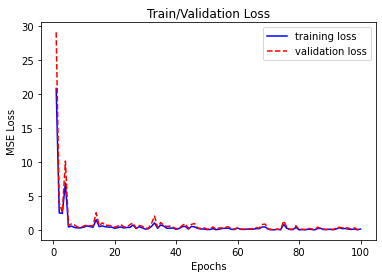

In [6]:
in_channel = 160
node_1 = 512
node_2 = 256
node_3 = 128
node_4 = 64
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 100

train(model_physics, optimizer, epoch)
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
torch.save(model_physics, PATH_CAL)

### Visualization of outcomes

In [7]:
model_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_trained, x_test_example)

# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:8])
print("Prediction    =", score_example[:8].reshape(8, 2))

Ground Truths = tensor([[ 9.8000,  3.9000],
        [ 5.7000,  1.7000],
        [ 7.7000,  2.5000],
        [11.6000,  3.7000],
        [ 4.5000,  1.2000],
        [ 9.8000,  3.4000],
        [ 5.9000,  2.0000],
        [11.4000,  3.1000]])
Prediction    = tensor([[10.3801,  4.2324],
        [ 5.0403,  1.7249],
        [ 7.1923,  2.3698],
        [11.5871,  4.0177],
        [ 3.3756,  1.2351],
        [10.6139,  3.6268],
        [ 5.0317,  1.9173],
        [11.0337,  3.4015]])
